In [94]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.seasonal import seasonal_decompose
import statistics
import math
import time

In [95]:
def prepare_data(data, sequence_length=12, train_test_split=.75):
    # data is a list
    data_normalized = scaler.fit_transform(np.array(data).reshape(-1, 1)).flatten()

    # sequence_length=12 means use past 12 hours of data to predict the next hour
    # data_X is a list of subsequences of length sequence_length.
    # data_y has the real target value that comes immedietly after the corresponding subsequence in data_X
    # LSTM model is trying to predict the ith value of data_y based on the ith subsequence in data_X
    # doing this is what allows the model to find patterns in the data
    data_X, data_y = [], []
    for i in range(len(data_normalized) - sequence_length):
        data_X.append(data_normalized[i:i+sequence_length])
        data_y.append(data_normalized[i+sequence_length])


    # convert python lists to numpy ndarrays
    data_X = np.array(data_X)
    data_y = np.array(data_y)

    # convert ndarrays to tensors, needed for pytorch
    X = torch.tensor(data_X, dtype=torch.float32)
    y = torch.tensor(data_y, dtype=torch.float32)

    # split data into train and test
    split = math.floor(len(X) * train_test_split)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # reshape data for LSTM model
    X_train = X_train.view(-1, sequence_length, 1)
    X_test = X_test.view(-1, sequence_length, 1)

    # prepare output
    train_loader = (X_train, y_train)
    test_loader = (X_test, y_test)
    return train_loader, test_loader, split, sequence_length

In [96]:
# Define LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size  # I found the optimal hidden layer size to be 50 (tested 50, 75, 100)
        # defining the different layers of the LSTM model
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        # specifies how each pass through the model works
        # Pytorch does this for me when the model is training, which is why it is never called explicitly in the code.
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [97]:
def Training(model, optimizer, train_loader, num_epochs=20):
    start = time.time()
    loss_function = nn.MSELoss()
    # MSE loss makes the most sense imo

    for i in range(num_epochs):
        for seq, labels in zip(train_loader[0], train_loader[1]):
            optimizer.zero_grad()         # reset gradient from pervious iterations

            # reset hidden layer
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)           # performs prediction on seq using the model
            single_loss = loss_function(y_pred, labels)     # calculate mse
            single_loss.backward()        # backpropogation
            optimizer.step()              # update optimizer weights

        if i%3 == 0:
            print("epoch: {:3} loss: {:10.8f} time elapsed: {}".format(
                i, single_loss.item(), time.time()-start))

    return model

In [98]:
def Testing(model, test_loader, split, sequence_length, timestamps, name, future=48):
    model.eval()
    y_pred = []
    for seq in test_loader[0]:  # Iter over the test loader
        with torch.no_grad():
            # reset the hidden layer for each seq, then append predicted value to y_pred
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            y_pred.append(model(seq).item())


    # transform y_pred to be similar to y_test
    y_pred_trans = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
    y_test = test_loader[1]


    # calculate and return the RMSE value, then plot the predicted and real values for the testing data
    mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_trans)
    rmse = np.sqrt(mse)
    print("RMSE: ", rmse)

    plt.figure(figsize=(15, 6))
    plt.plot(timestamps[split+sequence_length:], y_pred_trans, label='Predicted')
    plt.plot(timestamps[split+sequence_length:], scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(), label='Real')
    plt.xlabel('Timestamp')
    plt.ylabel('CPU Usage')
    plt.title('Real vs Predicted CPU Usage')
    plt.legend()
    plt.savefig(name)
    plt.show()

    return rmse, y_pred

In [99]:
df = pd.read_csv('by_half_hour.csv',  parse_dates=True)
timestamp_list = df["Timestamp"].tolist()
timestamps = pd.to_datetime(timestamp_list)
cpu_data = df["Avg_CPU_95"].tolist()

# MinMaxScaler scales the data so that it is all within the range of (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00674638 time elapsed: 2.083843231201172
epoch:   3 loss: 0.00375696 time elapsed: 8.19034218788147
epoch:   6 loss: 0.00186557 time elapsed: 14.881008625030518
epoch:   9 loss: 0.00082160 time elapsed: 20.763029098510742
epoch:  12 loss: 0.00034319 time elapsed: 27.426066637039185
epoch:  15 loss: 0.00015896 time elapsed: 33.396568059921265
epoch:  18 loss: 0.00008194 time elapsed: 40.099687576293945
epoch:  21 loss: 0.00004270 time elapsed: 46.06909132003784
epoch:  24 loss: 0.00002057 time elapsed: 52.775060415267944
RMSE:  0.4328621736287319


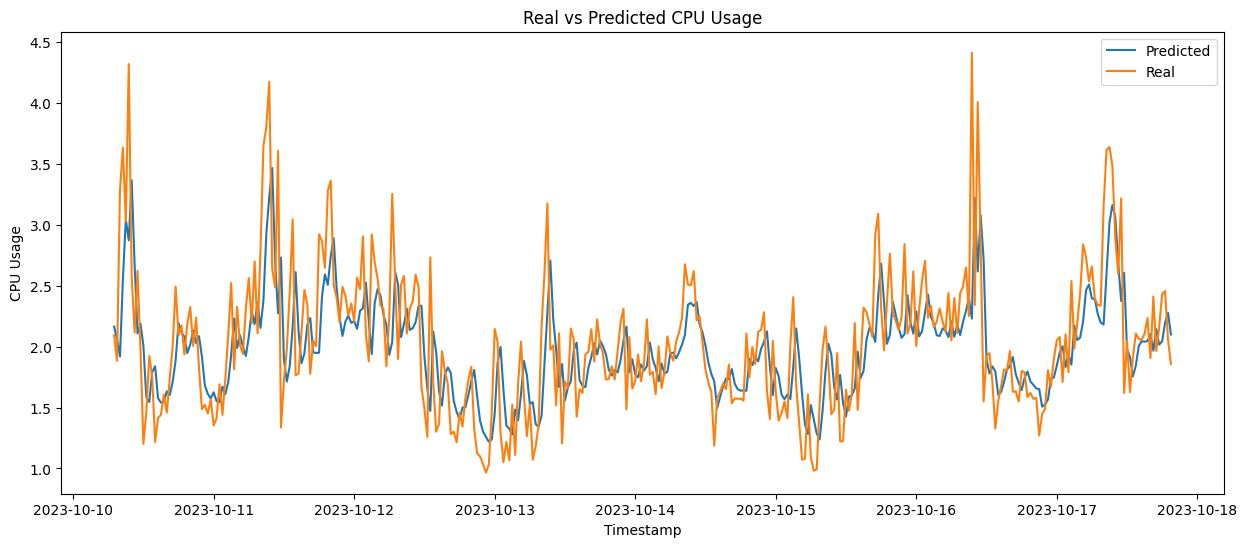

rmse:  0.4328621736287319


In [100]:
train, test, split, sequence_length = prepare_data(cpu_data, sequence_length=12, train_test_split=.75)
model = LSTMModel(hidden_layer_size=50)
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

result = Training(model, optimizer, train, num_epochs=25)
rmse, Y_Pred = Testing(result, test, split, sequence_length, timestamps, "Real_Pred_Graph")
print("rmse: ", rmse)

In [101]:
print("Range of Data:  " , max(cpu_data)-min(cpu_data))

Range of Data:   4.464884636118599


# Testing on Other Data

In [102]:
# The new dataset we received from Lockheed
df2 = pd.read_csv('LSTM_by_time_period.csv',  parse_dates=True)
timestamps2_list = df2["Timestamp"].tolist()
timestamps2 = pd.to_datetime(timestamps2_list)
cpu_data2 = df2["Avg_CPU_95"].tolist()

In [103]:
# we dont want to train the model again on this data, just test on it, hence the split=0
# if split=0, train2 is empty
train2, test2, split2, seq_len2 = prepare_data(cpu_data2, train_test_split=0)

RMSE:  0.41885188212042757


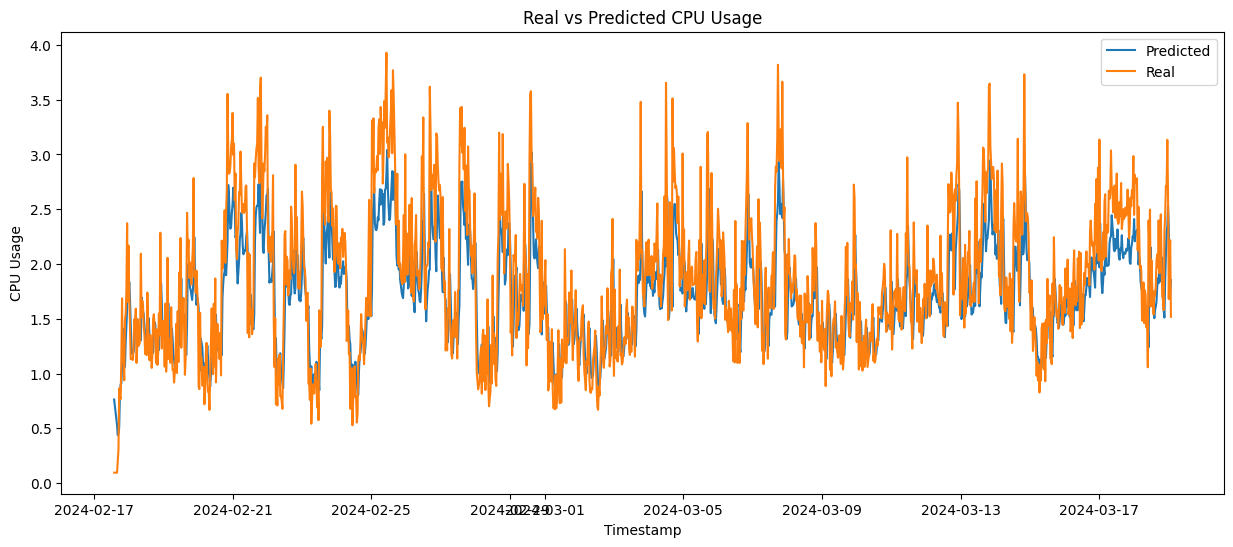

In [105]:
rmse2, y_pred2 = Testing(result, test2, split2, seq_len2, timestamps2, "Jan-Feb_Graph")

In [106]:
print(max(cpu_data2)-min(cpu_data2))

3.92908


# Custom Time Window

In [107]:
def time_window_testing(model, test_loader, timestamps, split=0, sequence_length=0, name="Limited_Time_Graph"):
    #
    # if user wants to only view a subset of the testing results, use this function
    # split and sequence_length should be 0 if not using the train dataset
    # if using the train dataset, they should be their real values.

    timestamps = timestamps[0+split+sequence_length:]


    print("earliest timestamp: ", timestamps[0])
    print("latest timestamp: ", timestamps[-1])
    start_time = input("select start time to view (YYYY-MM-DD HH:SS:00):  ")
    end_time = input("select end time to view (YYYY-MM-DD HH:SS:00):  " )


    try:
        start_time = pd.to_datetime(start_time)
    except ValueError:
        start_time = pd.to_datetime(timestamps[0])

    try:
        end_time = pd.to_datetime(end_time)
    except ValueError:
        end_time = pd.to_datetime(timestamps[-1])


    if start_time < timestamps[0]:
        start_time=timestamps[0]
    if end_time > timestamps[-1]:
        end_time=timestamps[-1]

    start_timestamp_index = timestamps.get_loc(start_time)
    end_timestamp_index = timestamps.get_loc(end_time)


    # rest is copied from Testing()
    model.eval()
    y_pred = []
    for seq in test_loader[0]:  # Iter over the test loader
        with torch.no_grad():
            # reset the hidden layer for each seq, then append predicted value to y_pred
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            y_pred.append(model(seq).item())

    # transform y_pred to be similar to y_test
    y_pred_trans = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
    y_test = test_loader[1]

    print("len y_pred: ", len(y_pred_trans))
    print("len y_test: ",len(y_test))
    print("len timestamps: ",len(timestamps))
    print()
    print("len y_pred: ", len(y_pred_trans[start_timestamp_index:end_timestamp_index]))
    print("len timestamps: ", len(timestamps[start_timestamp_index:end_timestamp_index+1]))



    # timestamps[0+split+sequence_length+start_timestamp_index] corresponds to y_pred_trans[0]

    # calculate and return the RMSE value, then plot the predicted and real values for the testing data
    mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_trans)
    rmse = np.sqrt(mse)
    print("RMSE: ", rmse)

    plt.figure(figsize=(15, 6))
    plt.plot(timestamps[start_timestamp_index:end_timestamp_index], y_pred_trans[start_timestamp_index:end_timestamp_index], label='Predicted')
    plt.plot(timestamps[start_timestamp_index:end_timestamp_index], scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()[start_timestamp_index:end_timestamp_index], label='Real')
    plt.xlabel('Timestamp')
    plt.ylabel('CPU Usage')
    plt.title('Real vs Predicted CPU Usage')
    plt.legend()
    plt.savefig(name)
    plt.show()

    return rmse, y_pred

earliest timestamp:  2024-02-17 14:00:00
latest timestamp:  2024-03-19 01:30:00
select start time to view (YYYY-MM-DD HH:SS:00):  0
select end time to view (YYYY-MM-DD HH:SS:00):  0
len y_pred:  1461
len y_test:  1461
len timestamps:  1461

len y_pred:  1460
len timestamps:  1461
RMSE:  0.4188518773720816


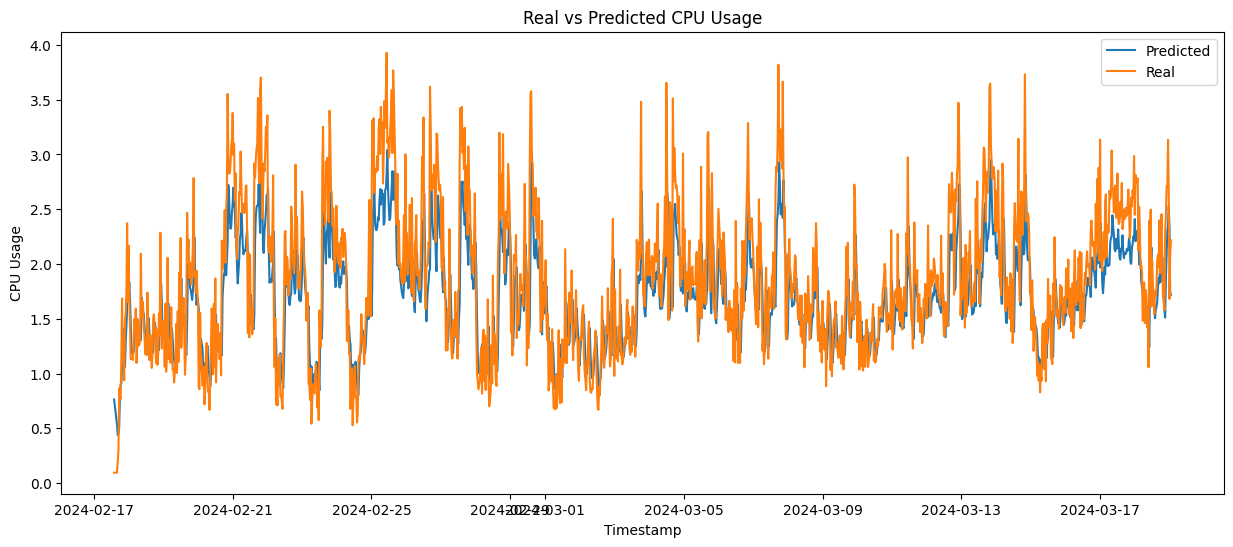

In [108]:
fil, ler = time_window_testing(result, test2, timestamps2, split2, seq_len2)

earliest timestamp:  2023-10-10 07:00:00
latest timestamp:  2023-10-17 19:30:00
select start time to view (YYYY-MM-DD HH:SS:00):  0
select end time to view (YYYY-MM-DD HH:SS:00):  0
len y_pred:  362
len y_test:  362
len timestamps:  362

len y_pred:  361
len timestamps:  362
RMSE:  0.3809179133634812


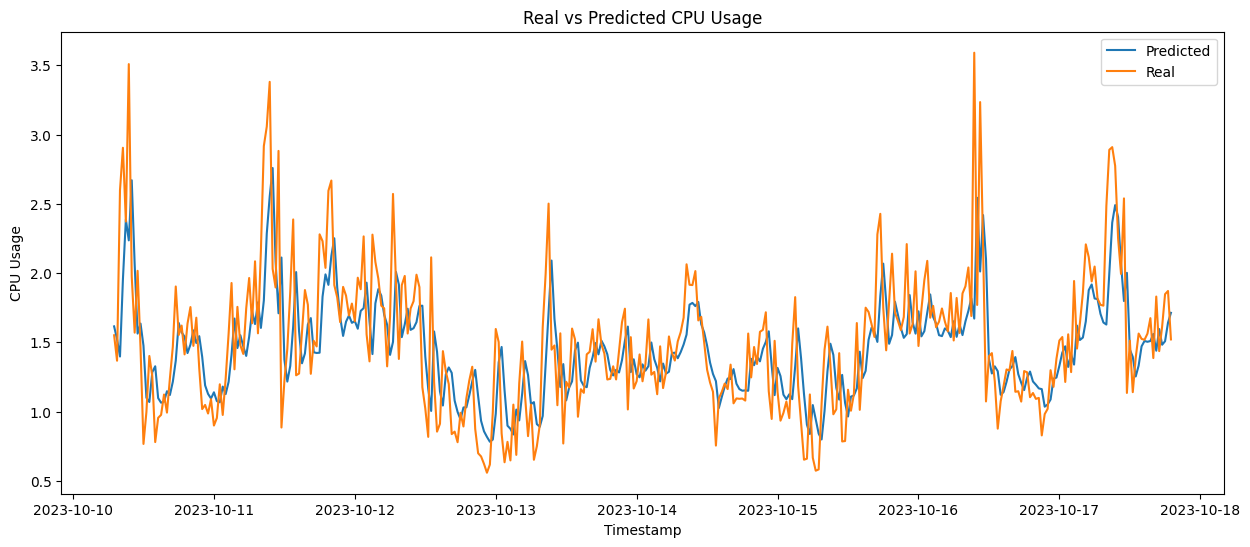

In [109]:
abra, cadabra = time_window_testing(result, test, timestamps, split, sequence_length)

# Scheduling

In [110]:
def scheduling(timestamps, y_pred, periods=48):

    last_24h_time = timestamps[-periods:]
    last_24h_pred = y_pred[-periods:]
    median_cpu = statistics.median(last_24h_pred)

    #print(last_24h_time)
    #print(last_24h_pred)
    #print(median_cpu)
    #print()

    on_off_df = pd.DataFrame(last_24h_time, columns=['Time'])
    on_off_df['Servers'] = False

    for index, row in on_off_df.iterrows():
        if last_24h_pred[index] > median_cpu:
            on_off_df.at[index, 'Servers'] = True

    return on_off_df

In [111]:
schedule = scheduling(timestamps, Y_Pred)
print(schedule)

                  Time  Servers
0  2023-10-16 20:00:00    False
1  2023-10-16 20:30:00    False
2  2023-10-16 21:00:00    False
3  2023-10-16 21:30:00    False
4  2023-10-16 22:00:00    False
5  2023-10-16 22:30:00    False
6  2023-10-16 23:00:00    False
7  2023-10-16 23:30:00    False
8  2023-10-17 00:00:00    False
9  2023-10-17 00:30:00    False
10 2023-10-17 01:00:00    False
11 2023-10-17 01:30:00    False
12 2023-10-17 02:00:00    False
13 2023-10-17 02:30:00    False
14 2023-10-17 03:00:00     True
15 2023-10-17 03:30:00     True
16 2023-10-17 04:00:00     True
17 2023-10-17 04:30:00     True
18 2023-10-17 05:00:00     True
19 2023-10-17 05:30:00     True
20 2023-10-17 06:00:00     True
21 2023-10-17 06:30:00     True
22 2023-10-17 07:00:00     True
23 2023-10-17 07:30:00     True
24 2023-10-17 08:00:00     True
25 2023-10-17 08:30:00     True
26 2023-10-17 09:00:00     True
27 2023-10-17 09:30:00     True
28 2023-10-17 10:00:00     True
29 2023-10-17 10:30:00     True
30 2023-

# Seasonality

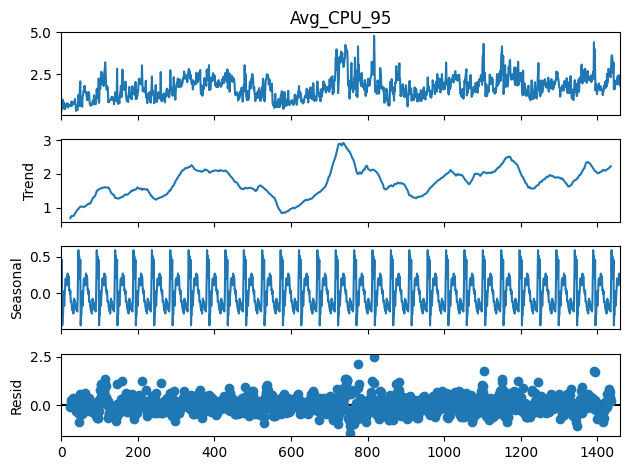

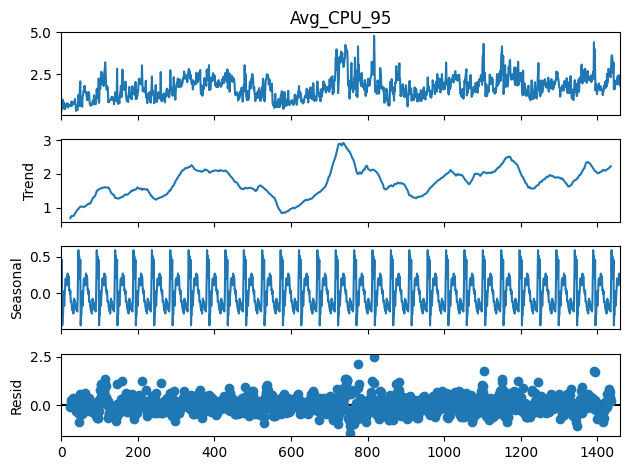

In [112]:
# Basic method of seeing trend and seasonality of data. period=48 because there are
# 48 observations per period, period being each day and there being 48 half-hour intervals each day
seasonal_res = seasonal_decompose(df['Avg_CPU_95'], period=48)
seasonal_res.plot()